In [ ]:
!pip install chromadb

## 大语言模型的检索功能的学习

In [1]:
import getpass  # 导入用于安全输入密码的模块
import os  # 导入操作系统相关的模块

# 首先，让我们下载所需的软件包并设置我们的 API 密钥：
def _set_env(key: str):
    """
    设置环境变量的函数。
    
    参数:
    key (str): 要设置的环境变量的名称。
    
    如果指定的环境变量名称在当前环境中不存在，则提示用户输入值并将其设置为该环境变量。
    """
    if key not in os.environ:  # 检查环境变量是否已存在
        os.environ[key] = getpass.getpass(f"{key}:")  # 如果不存在，提示用户输入并设置环境变量

_set_env("OPENAI_API_KEY")  # 调用函数设置 OPENAI_API_KEY 环境变量

In [ ]:
# 从 langchain_community 导入 WebBaseLoader，用于加载网页内容
from langchain_community.document_loaders import WebBaseLoader
# 从 langchain_community 导入 Chroma，用于创建向量数据库
from langchain_community.vectorstores import Chroma
# 从 langchain_openai 导入 OpenAIEmbeddings，用于生成文本的嵌入表示
from langchain_openai import OpenAIEmbeddings
# 从 langchain_text_splitters 导入 RecursiveCharacterTextSplitter，用于分割文本
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 定义要加载的网页 URL 列表
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# 使用 WebBaseLoader 加载每个 URL 的内容，并将结果存储在 docs 列表中
docs = [WebBaseLoader(url).load() for url in urls]
# 将嵌套列表 docs 展平为单一列表 docs_list
docs_list = [item for sublist in docs for item in sublist]

# 创建一个文本分割器，设置每个块的大小和重叠部分
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
# 使用文本分割器将文档分割成更小的部分
doc_splits = text_splitter.split_documents(docs_list)

# 将分割后的文档添加到向量数据库中
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",  # 设置集合名称
    embedding=OpenAIEmbeddings(),  # 使用 OpenAI 的嵌入表示
)
# 将向量数据库转换为检索器
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [12]:
# 获取集合中所有文档的ID
all_ids = vectorstore.get()["ids"]
print(f"数据库中共有 {len(all_ids)} 个文档")

# 方法2：获取所有文档内容和元数据
all_documents = vectorstore.get()
print("文档ID:", all_documents["ids"][:5])           # 只显示前5个ID
print("文档内容:", all_documents["documents"][:5])    # 只显示前5个文档内容
print("文档元数据:", all_documents["metadatas"][:5])  # 只显示前5个文档元数据


数据库中共有 563 个文档
文档ID: ['b5e863bf-f6de-4e33-9a38-239e3c067552', 'f056e6ce-5a6b-446f-ba6e-af1077b58371', '19b6e5ea-c776-4b21-a181-756f053b1e87', '7d6be435-9d8d-4082-92c7-abcb4f8f9a74', '5851e6a1-80c5-4ff2-b567-a70961cb4a5d']
文档内容: ["LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ", "Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng", 'LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponen

In [18]:
# 方法3：相似度搜索查看文档
query = "哪些用来做agent的工具"
docs = vectorstore.similarity_search(query, k=5)  # 获取5个最相关的文档
for i, doc in enumerate(docs):
    print(f"相关文档 {i+1}:")
    print(f"内容: {doc.page_content[:100]}...")  # 显示前100个字符
    print(f"元数据: {doc.metadata}")
    print("-" * 50)

相关文档 1:
内容: Tool use

The agent learns to call external APIs for extra information that is missing from the mode...
元数据: {'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory

In [19]:
# 方法4：使用retriever检索文档
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
retrieved_docs = retriever.get_relevant_documents(query)
for i, doc in enumerate(retrieved_docs):
    print(f"检索到的文档 {i+1}:")
    print(f"内容: {doc.page_content[:100]}...")
    print(f"元数据: {doc.metadata}")
    print("-" * 50)



检索到的文档 1:
内容: Tool use

The agent learns to call external APIs for extra information that is missing from the mode...
元数据: {'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemo

In [20]:
# 方法5：通过MMR(最大边际相关性)方法获取多样化结果
mmr_docs = vectorstore.max_marginal_relevance_search(query, k=5, fetch_k=10)
for i, doc in enumerate(mmr_docs):
    print(f"MMR文档 {i+1}:")
    print(f"内容: {doc.page_content[:100]}...")
    print(f"元数据: {doc.metadata}")
    print("-" * 50)

# 方法6：获取集合统计信息
collection = vectorstore._collection
print(f"集合名称: {collection.name}")
print(f"集合中的元素数量: {collection.count()}")

MMR文档 1:
内容: Tool use

The agent learns to call external APIs for extra information that is missing from the mode...
元数据: {'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemor

In [3]:
# 从langchain.tools.retriever导入create_retriever_tool函数
from langchain.tools.retriever import create_retriever_tool

# 创建一个检索工具，用于检索Lilian Weng博客文章的信息
retriever_tool = create_retriever_tool(
    retriever,  # 使用之前定义的retriever
    "retrieve_blog_posts",  # 工具的名称
    "搜索并返回关于Lilian Weng在LLM代理、提示工程和对LLM的对抗攻击方面的博客文章的信息。"  # 工具的描述
)

# 将检索工具添加到工具列表中
tools = [retriever_tool]

In [4]:
from typing import Annotated, Sequence   # 导入注解和序列类型
from typing_extensions import TypedDict  # 导入TypedDict以定义类型字典

from langchain_core.messages import BaseMessage   # 导入基础消息类
from langgraph.graph.message import add_messages  # 导入添加消息的函数


class AgentState(TypedDict):  # 定义代理状态的类型字典
    # add_messages函数定义了如何处理更新
    messages: Annotated[Sequence[BaseMessage], add_messages]  # 消息序列，使用add_messages进行处理

In [5]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    确定检索到的文档是否与问题相关。

    参数:
        state (messages): 当前状态

    返回:
        str: 关于文档是否相关的决策
    """

    print("---检查相关性---")

    # 数据模型
    class grade(BaseModel):
        """用于相关性检查的二进制评分。"""

        binary_score: str = Field(description="相关性评分 'yes' 或 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # 带工具和验证的LLM
    llm_with_tool = model.with_structured_output(grade)

    # 提示
    prompt = PromptTemplate(
        template="""你是一个评估检索到的文档与用户问题相关性的评分者。 \n 
        这是检索到的文档: \n\n {context} \n\n
        这是用户的问题: {question} \n
        如果文档包含与用户问题相关的关键词或语义，请将其评分为相关。 \n
        给出一个二进制评分 'yes' 或 'no' 来指示文档是否与问题相关。""",
        input_variables=["context", "question"],
    )

    # 链接
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---决策: 文档相关---")
        return "generate"

    else:
        print("---决策: 文档不相关---")
        print(score)
        return "rewrite"


In [ ]:
### Nodes

def agent(state):
    """
    调用代理模型，根据当前状态生成响应。给定问题后，它将决定使用检索工具进行检索，或简单结束。

    参数:
        state (messages): 当前状态

    返回:
        dict: 更新后的状态，其中包含附加到消息的代理响应
    """
    print("---调用代理---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # 我们返回一个列表，因为这将被添加到现有列表中
    return {"messages": [response]}


def rewrite(state):
    """
    转换查询以生成更好的问题。

    参数:
        state (messages): 当前状态

    返回:
        dict: 更新后的状态，其中包含重新表述的问题
    """

    print("---转换查询---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    查看输入并尝试推理潜在的语义意图/含义。 \n 
    这是初始问题:
    \n ------- \n
    {question} 
    \n ------- \n
    形成一个改进的问题: """,
        )
    ]

    # 评分器
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    生成答案

    参数:
        state (messages): 当前状态

    返回:
         dict: 更新后的状态，其中包含重新表述的问题
    """
    print("---生成---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # 提示
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # 后处理
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # 链接
    rag_chain = prompt | llm | StrOutputParser()

    # 运行
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "提示[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # 显示提示的样子

********************提示[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [ ]:
# 从 langgraph.graph 导入 END, StateGraph, START
from langgraph.graph import END, StateGraph, START
# 从 langgraph.prebuilt 导入 ToolNode
from langgraph.prebuilt import ToolNode

# 定义一个新的图
workflow = StateGraph(AgentState)

# 定义我们将循环的节点
workflow.add_node("agent", agent)        # 代理节点
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 检索节点
workflow.add_node("rewrite", rewrite)    # 重写问题的节点
workflow.add_node(
    "generate", generate
)
# 调用代理节点以决定是否进行检索
workflow.add_edge(START, "agent")

# 决定是否进行检索
workflow.add_conditional_edges(
    "agent",
    # 评估代理的决策
    tools_condition,
    {
        # 将条件输出转换为我们图中的节点
        "tools": "retrieve",
        END: END,
    },
)

# 在调用 `action` 节点后采取的边
workflow.add_conditional_edges(
    "retrieve",
    # 评估代理的决策
    grade_documents,
)
workflow.add_edge("generate", END)  # 生成节点到结束节点的边
workflow.add_edge("rewrite", "agent")  # 重写节点到代理节点的边

# 编译图
graph = workflow.compile()

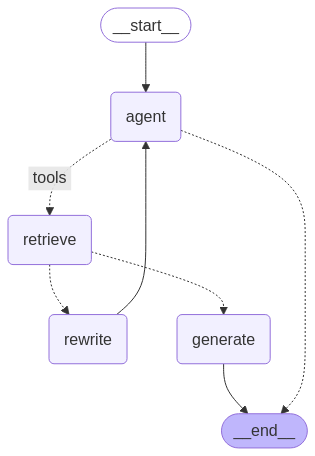

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


## 测试最终的结果

In [8]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---调用代理---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_NKmhEUfJ32hqA2t93VLKOyeu', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_101a39fff3'}, id='run-19838d75-d1a6-49e1-9276-5df3e86cdce8-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_NKmhEUfJ32hqA2t93VLKOyeu', 'type': 'tool_call'}])]}
'\n---\n'
---检查相关性---
---决策: 文档相关---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Table of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery 